In [2]:
import json
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
from names_dataset import NameDataset
from tqdm import tqdm
from spacy.tokenizer import Tokenizer
import spacy
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
# nlp = spacy.load("en_core_web_sm")
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score

/Users/augusttollerup/Documents/KSEM2/ABA/PII_data_detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_model = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

### Pre-Note
Token labels are presented in BIO (Beginning, Inner, Outer) format. The PII type is prefixed with “B-” when it is the beginning of an entity. If the token is a continuation of an entity, it is prefixed with “I-”. Tokens that are not PII are labeled “O”.

**Model idea** Lets instead of using the predefined token space, we define a new one without BIO definition, but where we concat tokens that are part of the same entity. We can then afterwards use SpaCy tokenizer to reverse the changes we made and get the labels.

In [5]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

In [6]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [7]:
labels = df.labels.explode().reset_index(drop=True)
labels_vc = labels.value_counts()
labels_vc

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

**THIS TRICK IS ONLY BECAUSE WE DO NOT CARE TO PARTICIPATE IN THE KAGGLE COMPETITION, BUT WE WANT TO USE THE DATA FOR OUR OWN PROJECTS.**

In [8]:
# Create new tokens by concatinating items in the tokens list until a 0 label is found
# we do this for each row
new_labels_dict = {
    'O': 'O',
    'B-URL_PERSONAL': 'URL_PERSONAL',
    'I-URL_PERSONAL': 'URL_PERSONAL',
    'B-EMAIL': 'EMAIL',
    'I-EMAIL': 'EMAIL',
    'B-ID_NUM': 'ID_NUM',
    'I-ID_NUM': 'ID_NUM',
    'I-STREET_ADDRESS': 'STREET_ADDRESS',
    'B-STREET_ADDRESS': 'STREET_ADDRESS',
    'I-PHONE_NUM': 'PHONE_NUM',
    'B-PHONE_NUM': 'PHONE_NUM',
    'B-USERNAME': 'USERNAME',
    'I-USERNAME': 'USERNAME',
    'B-PHONE_NUM': 'PHONE_NUM',
    'I-PHONE_NUM': 'PHONE_NUM',
    'I-URL_PERSONAL': 'URL_PERSONAL',
    'B-URL_PERSONAL': 'URL_PERSONAL',
    'B-NAME_STUDENT': 'NAME_STUDENT',
    'I-NAME_STUDENT': 'NAME_STUDENT',
}

def create_new_tokens(row):
    tokens = row["tokens"]
    labels = row["labels"]
    new_tokens = []
    new_labels = []
    building_token, building_token_label = "", None
    for token, label in zip(tokens, labels):
        # If the token is in the new_labels_dict, we start building the new token until we find a 0 label
        if label in new_labels_dict and label != "O" and label != "I-NAME_STUDENT" and label != "B-NAME_STUDENT":
            building_token += token
            building_token_label = new_labels_dict[label]
        # Else the new token is not PII class so we append the building token and the token to the new tokens list
        else:
            if building_token:
                new_tokens.append(building_token)
                new_labels.append(building_token_label)
            
            new_tokens.append(token)
            new_labels.append(label)

            building_token = ""

    return new_tokens, new_labels

In [9]:
df[["new_tokens", "new_labels"]] = df.apply(create_new_tokens, axis=1, result_type="expand")

In [10]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels,new_tokens,new_labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...","[Design, Thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[Diego, Estrada, \n\n, Design, Thinking, Assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[Reporting, process, \n\n, by, Gilberto, Gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT...","[Design, Thinking, for, Innovation, \n\n, Sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...","[Assignment, :, , Visualization, , Reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [11]:
tokens_exploded = df.tokens.explode().reset_index(drop=True)
labels_exploded = df.labels.explode().reset_index(drop=True)
labels_exploded.value_counts()

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

In [12]:
tokens_exploded[:20]

0         Design
1       Thinking
2            for
3     innovation
4      reflexion
5              -
6          Avril
7           2021
8              -
9       Nathalie
10         Sylla
11          \n\n
12     Challenge
13             &
14     selection
15          \n\n
16           The
17          tool
18             I
19           use
Name: tokens, dtype: object

In [13]:
ids = labels_exploded[labels_exploded == 'B-NAME_STUDENT'].index
print(" ".join(tokens_exploded[ids[0]-15:ids[0]+15]))
print("-"*50)
print(" ".join(tokens_exploded[ids[1]-15:ids[1]+15]))


--------------------------------------------------
hours for a workshop . 

 Design Thinking for innovation reflexion - Avril 2021 - Nathalie Sylla 

 After modelling the mind map on paper , I propose to the


In [14]:
ids = labels_exploded[labels_exploded == 'I-STREET_ADDRESS'].index
tokens_exploded[ids]

861200           Smith
861201         Centers
861202             Apt
861203               .
861204             656
861205              \n
861206     Joshuamouth
861207               ,
861208              RI
861209           95963
1445331          Erika
1445332         Bypass
1445333            Apt
1445334              .
1445335            419
1445336             \n
1445337    Andreahaven
1445338              ,
1445339             IL
1445340          54207
Name: tokens, dtype: object

In [15]:
new_tokens_exploded = df.new_tokens.explode().reset_index(drop=True)
new_labels_exploded = df.new_labels.explode().reset_index(drop=True)
new_labels_exploded.value_counts()

new_labels
O                 4989794
B-NAME_STUDENT       1365
I-NAME_STUDENT       1096
URL_PERSONAL          110
ID_NUM                 78
EMAIL                  39
USERNAME                6
PHONE_NUM               6
STREET_ADDRESS          2
Name: count, dtype: int64

In [16]:
ids = new_labels_exploded[new_labels_exploded == 'STREET_ADDRESS'].index
new_tokens_exploded[ids]

861183     591SmithCentersApt.656\nJoshuamouth,RI95963
1445304     743ErikaBypassApt.419\nAndreahaven,IL54207
Name: new_tokens, dtype: object

### ID_NUM

In [17]:
idx = new_labels_exploded[new_labels_exploded == "ID_NUM"].index
b_ids = new_tokens_exploded[idx]
b_ids.shape

(78,)

In [18]:
reg = r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
specific_id = b_ids.str.contains(reg)
ids_in_tokens = new_tokens_exploded.str.contains(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  73
Regex finding Ids in all tokens:  248

Accuracy Regex finding Ids in label specific:  0.9358974358974359
Error of missclassification in whole 4.967455156699174e-05


### EMAIL

In [19]:
idx = new_labels_exploded[new_labels_exploded == "EMAIL"].index
b_email = new_tokens_exploded[idx]
b_email.shape

(39,)

In [20]:
reg = r'[\w\.-]+@[\w\.-]+'
specific_id = b_email.str.match(reg)
ids_in_tokens = new_tokens_exploded.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  39
Regex finding Ids in all tokens:  49

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 9.814729946704014e-06


### URL_PERSONAL

In [21]:
idx = new_labels_exploded[new_labels_exploded == "URL_PERSONAL"].index
b_url = new_tokens_exploded[idx]
b_url.shape

(110,)

In [22]:
reg = r'https?://\S+|www\.\S+'
specific_id = b_url.str.match(reg)
ids_in_tokens = new_tokens_exploded.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  109
Regex finding Ids in all tokens:  327

Accuracy Regex finding Ids in label specific:  0.990909090909091
Error of missclassification in whole 6.54982998484125e-05


### PHONE_NUM

In [23]:
idx = new_labels_exploded[new_labels_exploded == "PHONE_NUM"].index
b_phone = new_tokens_exploded[idx]
b_phone.shape

(6,)

In [24]:
reg = r'\(?(\d{3})\)?[-. ]?(\d{3})[-. ]?(\d{4})(x\d{2,5})?'
specific_id = b_phone.str.match(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  6
Regex finding Ids in all tokens:  327

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 6.54982998484125e-05


## Model Definition
We will attempt to create the simplest model possible. The model will evaluate each token and pass it through a couple functions to evaluate it. If one of the functions returns true, the token will be considered a keyword. The model will then return the keyword and the index of the token in the input string.

### Model Functions
- **email** This function will use regex to identify if the token is an email address.
- **phone_num** This function will use regex to identify if the token is a phone number.
- **address** This function will use regex to identify if the token is an address.
- **username** This function will use a word embedding model to identify if the token is a common word and if not then we flag it as a username.
- **personal_id** This function will use regex to identify if the token is a personal id.


In [25]:
names = NameDataset()

**To do**
Maybe we could make some more features for capitalised words etc.

In [26]:
names.first_names.get("August")

{'country': {'AT': 0.071,
  'BE': 0.044,
  'DE': 0.059,
  'DK': 0.052,
  'MY': 0.052,
  'NL': 0.071,
  'SA': 0.047,
  'SE': 0.069,
  'US': 0.341,
  'ZA': 0.195},
 'gender': {'F': 0.141, 'M': 0.859},
 'rank': {'AT': 351,
  'BE': 1628,
  'DE': 1997,
  'DK': 248,
  'MY': 6402,
  'NL': 1910,
  'SA': 14254,
  'SE': 306,
  'US': 2869,
  'ZA': 2723}}

In [27]:
import re

def tokenizer(text):
    # Remove excessive line breaks or spaces
    text = re.sub('(\r\n){2,}', ' ', text)
    
    # Convert the text to lowercase and split into tokens
    tokens = text.lower().split(" ")
    
    return tokens

class PiiModel:
    def __init__(self, text: str = None, 
                 names_dataset = None, tokens: list = None, 
                 significant_tokens: dict = None, 
                 dataframe: pd.DataFrame = None, full_text: str = None):
        self.text = text
        self.names = names_dataset
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.name_rank_threhsold = 1500
        self.country_threshold = 0.01
        self.significant_tokens = significant_tokens
        self.feature_df = pd.DataFrame()
        self.input_df = dataframe
        self.full_text = full_text
        pass
    
    def get_firstname(self, name: str) -> bool:
        found_name = self.names.first_names.get(name.capitalize())

        if not found_name:
            return False
        country = found_name["country"]
        # If any of the countries has a higher percentage than the threshold and the rank is lower than the threshold
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False

    
    def get_lastname(self, lastname: str) -> bool:
        found_name = self.names.last_names.get(lastname.capitalize())
        # we check if the max country is higher than a threshold then we say it is a valid name
        if not found_name:
            return False
        country = found_name["country"]
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False
    
    def get_email_regex(self):
        return r'[\w\.-]+@[\w\.-]+'
    
    def get_phone_number_regex(self):
        return r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    
    def get_address_regex(self):
        return r'\d{1,5}\s\w.\s(\b\w*\b\s){1,2}\w*\.'
    
    def get_personal_id_regex(self):
        return r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
    
    def get_url_personal_regex(self):
        return r'https?://[\w\.-]+'
    
    def numb_percent(self, text: str) -> float:
        return sum(c.isdigit() for c in text) / len(text)
    
    def word_length(self, text: str) -> int:
        return len(text)
    
    def is_punctuationmark(self, text: str) -> bool:
        return text in [".", ",", "!", "?", ";", ":"]
    
    def stop_words(self, text: str) -> bool:
        return text in nlp.Defaults.stop_words
    
    def capitalize(self, text: str) -> bool:
        return text[0].strip().isupper()
    
    def NER_ingest(self, text: str):
        return ner_model(text)

    def contextual_ner_person(self, text: str) -> bool:
        return text in list(self.NER_persons)
    
    def contextual_ner_location(self, text: str) -> bool:
        return text in (self.NER_locations)
    
    def check_preceding_contextual_tokens(self, index, label):
        # Extract relevant tokens directly, avoiding repeated DataFrame row access
        start_index = max(0, index-2)
        tokens_to_check = self.feature_df['token'][start_index:index]
        
        # Get the set of significant tokens for the label, defaulting to an empty set if not found
        significant_tokens_set = self.significant_tokens.get(label, set())
        
        # Check if any of the tokens to check are in the significant tokens set
        return any(token in significant_tokens_set for token in tokens_to_check)

    
    def build_df(self, text: str = "", tokens: list = None, labels: list = None) -> pd.DataFrame:
        token_indices = self.tokens
        if not self.tokens and text != "":
            token_indices = self.tokenizer(text)
            self.tokens = token_indices
        if tokens:
            token_indices = tokens
        elif self.input_df is not None:
            token_indices = self.input_df["tokens"]
        self.feature_df["token"] = token_indices

        self.feature_df['labels'] = labels
        return None

    def build_features(self) -> list[tuple[int, str]]:
        # Computing Features
        self.feature_df['first_name'] = self.feature_df['token'].apply(self.get_firstname)
        self.feature_df['last_name'] = self.feature_df['token'].apply(self.get_lastname)
        self.feature_df['email'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_email_regex(), x)))
        self.feature_df['phone_number'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_phone_number_regex(), x)))
        self.feature_df['address'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_address_regex(), x)))
        self.feature_df['personal_id'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_personal_id_regex(), x)))
        self.feature_df['url'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_url_personal_regex(), x)))
        self.feature_df['capitalized'] = self.feature_df['token'].apply(lambda x: self.capitalize(x))
        self.feature_df['numb_percent'] = self.feature_df['token'].apply(self.numb_percent)
        self.feature_df['word_length'] = self.feature_df['token'].apply(self.word_length)
        self.feature_df['norm_index'] = self.feature_df.index / len(self.feature_df)
        self.feature_df['is_punctuation'] = self.feature_df['token'].apply(self.is_punctuationmark)
        self.feature_df['stop_word'] = self.feature_df['token'].apply(self.stop_words)

        ingested = self.NER_ingest(self.full_text)

        self.NER_persons = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'PER']).explode().reset_index(drop=True)
        self.NER_locations = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'LOC']).explode().reset_index(drop=True)

        self.feature_df['contextual_ner_person'] = self.feature_df['token'].apply(self.contextual_ner_person)
        self.feature_df['contextual_ner_location'] = self.feature_df['token'].apply(self.contextual_ner_location)

        # Window
        for i in range(1, 6):
            self.feature_df[f'r_neighboured_email_{i}'] = self.feature_df['email'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_email_{i}'] = self.feature_df['email'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_address_{i}'] = self.feature_df['address'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_address_{i}'] = self.feature_df['address'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_url_{i}'] = self.feature_df['url'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_url_{i}'] = self.feature_df['url'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(i).fillna(False)


        if self.input_df is not None:
            self.feature_df["text_index"] = self.input_df.text_index
        # Add a new feature for each label based on contextual tokens
        for label in self.significant_tokens.keys():
            feature_name = f'{label.lower()}_contextual_presence'
            self.feature_df[feature_name] = [self.check_preceding_contextual_tokens(i, label) for i in range(len(self.feature_df))]


        return None


## Data building


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    df.labels, 
                                                    test_size=0.33, 
                                                    random_state=42)

# Preceeding Words analysis on Xtrain:

In [66]:
dfs_analysis = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    model.build_df(tokens=tokens, labels=labels)
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_analysis.append(model.feature_df)

X_analysis = pd.concat(dfs_analysis, axis=0)
X_analysis.fillna(0, inplace=True)


100%|██████████| 4560/4560 [00:01<00:00, 2564.11it/s]


In [67]:
_analysis_df = X_analysis[['token', 'labels']].reset_index()

In [68]:
_analysis_df.labels.unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-ID_NUM',
       'B-URL_PERSONAL', 'B-EMAIL', 'B-USERNAME', 'I-URL_PERSONAL',
       'I-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS'], dtype=object)

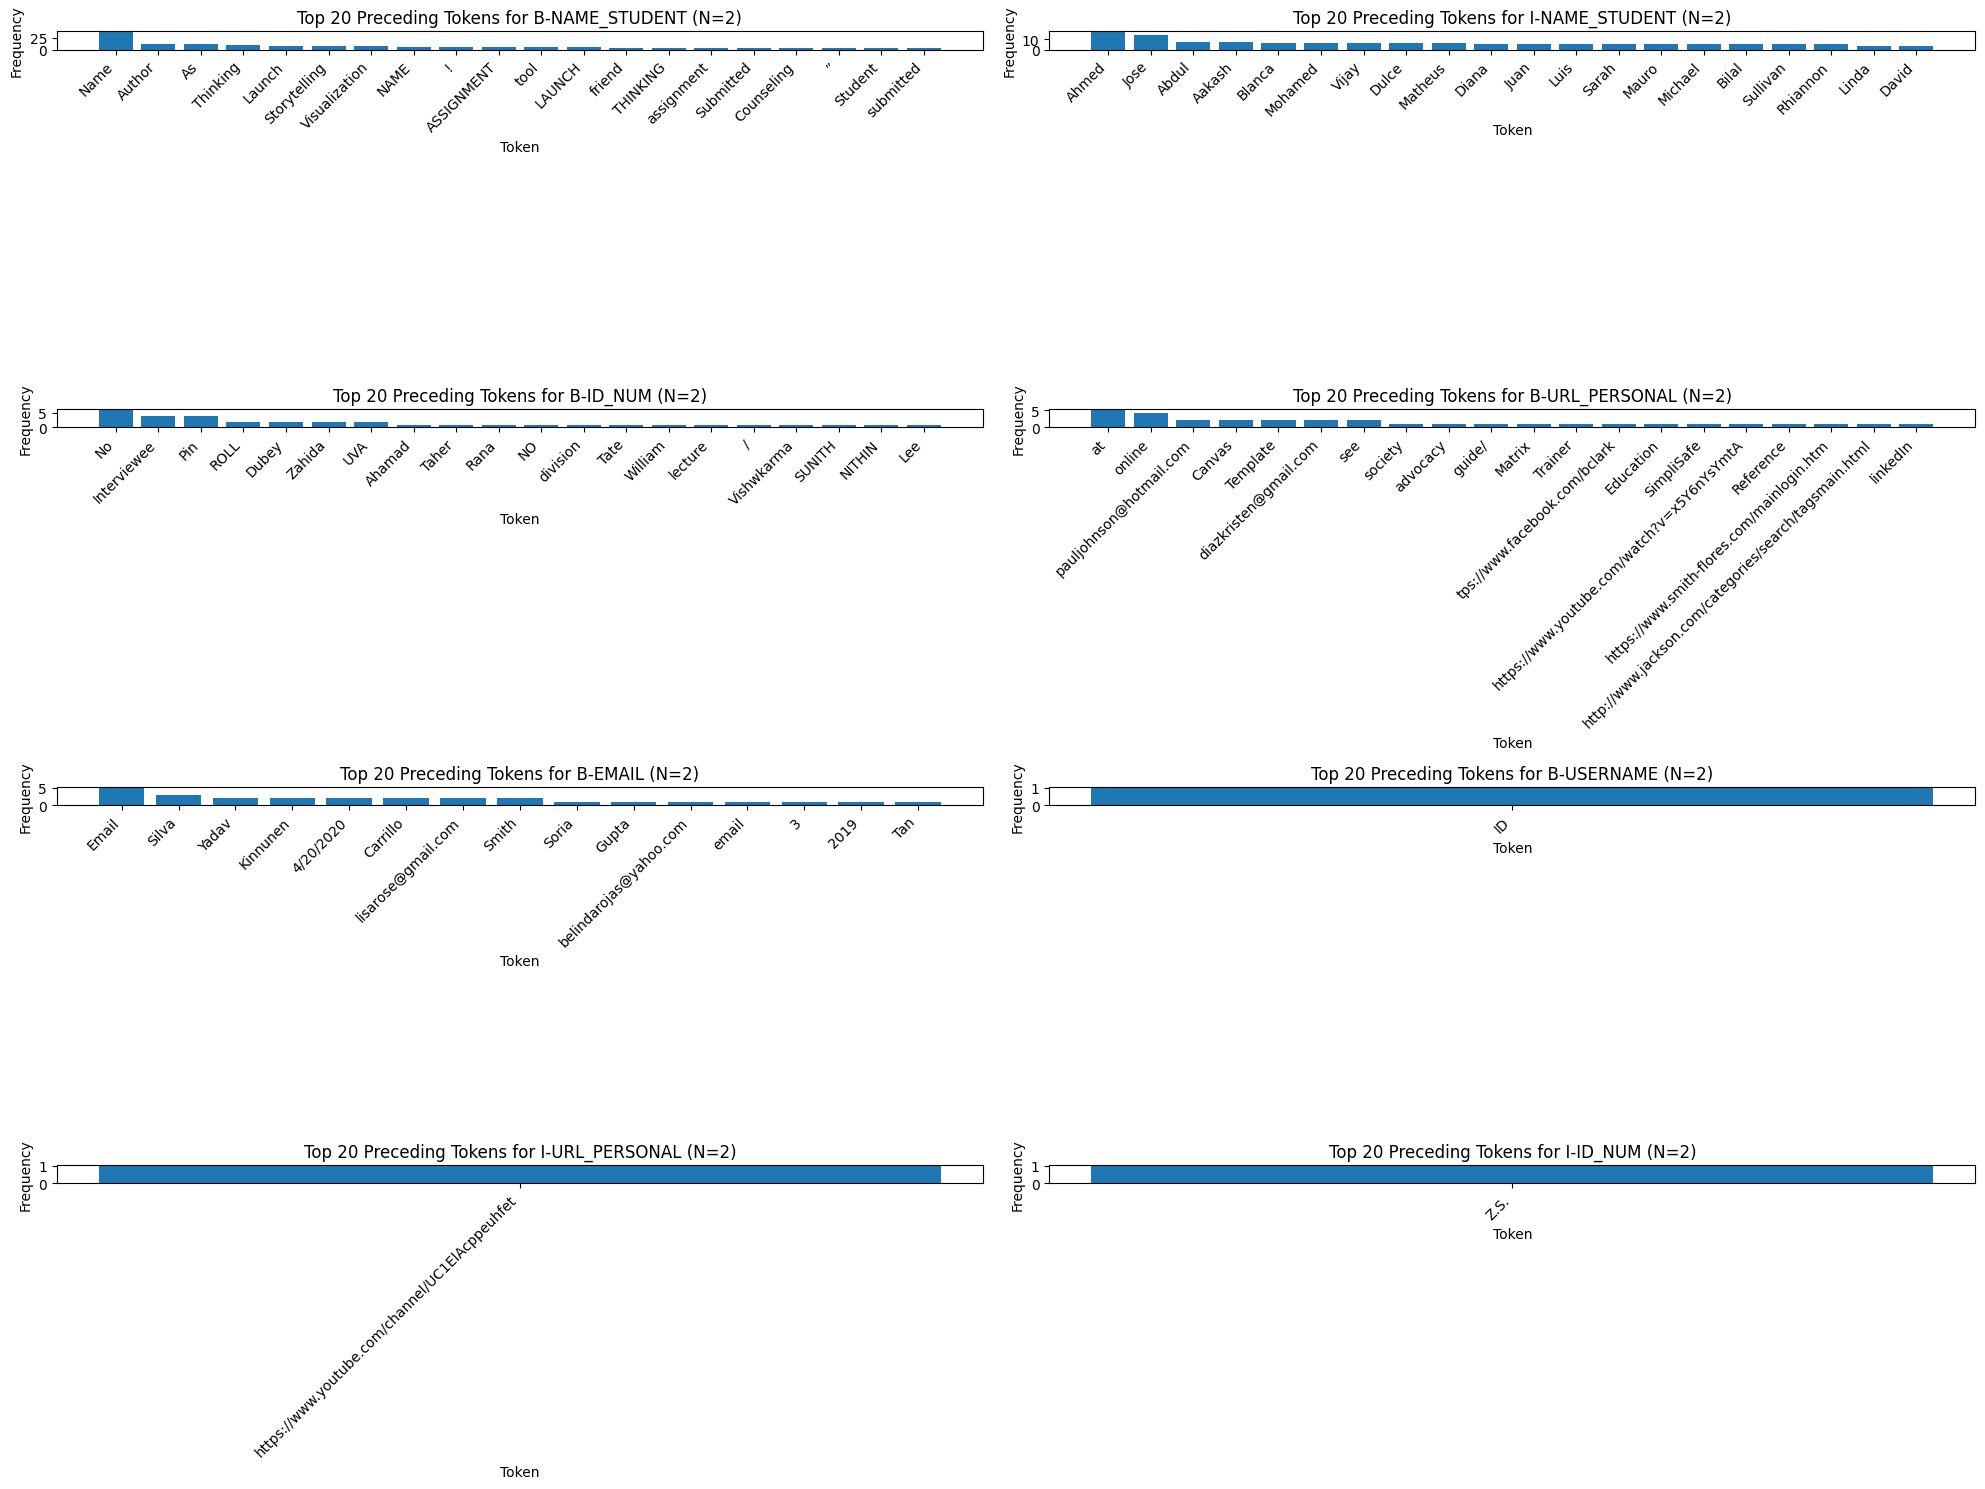

In [69]:
def get_preceding_tokens(row_index, N, dataframe):
    # Calculate the start index to avoid negative indexing
    start_index = max(0, row_index - N)
    # Extract preceding N tokens, if the row_index is not at the very beginning
    if start_index < row_index:
        return dataframe.iloc[start_index:row_index]['token'].tolist()
    else:
        return []


N = 2  # Example: Look 5 tokens back
labels_of_interest = ['B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-ID_NUM',
       'B-URL_PERSONAL', 'B-EMAIL', 'B-USERNAME', 'I-URL_PERSONAL',
       'I-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS']

# Initialize a dictionary to hold token frequencies for each label
token_frequencies_by_label = {label: {} for label in labels_of_interest}

for label in labels_of_interest:
    # Filter rows for the specific label
    label_indices = _analysis_df[_analysis_df['labels'] == label].index
    
    # Collect preceding tokens for each occurrence of the label
    for index in label_indices:
        preceding_tokens = get_preceding_tokens(index, N, _analysis_df)
        for token in preceding_tokens:
            if token in token_frequencies_by_label[label]:
                token_frequencies_by_label[label][token] += 1
            else:
                token_frequencies_by_label[label][token] = 1


from collections import defaultdict

# This dictionary will count the occurrences of each token across labels
token_occurrences_across_labels = defaultdict(int)

# Count occurrences of each token across different labels
for label, frequencies in token_frequencies_by_label.items():
    for token in frequencies.keys():
        token_occurrences_across_labels[token] += 1

# Identify tokens that appear in more than one label's frequency dictionary
common_tokens = {token for token, count in token_occurrences_across_labels.items() if count > 1}


# Remove common tokens from each label's frequency dictionary
filtered_token_frequencies_by_label = {
    label: {token: frequency for token, frequency in frequencies.items() if token not in common_tokens}
    for label, frequencies in token_frequencies_by_label.items()
}


plt.figure(figsize=(20, 15))

for i, (label, frequencies) in enumerate(filtered_token_frequencies_by_label.items(), 1):
    # Sort the frequencies dictionary by value and get the top 20 tokens
    try:
        top_tokens = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
        tokens, counts = zip(*top_tokens)  # Unzip the token-count pairs
        
        # Plot
        plt.subplot(4, 2, i)  # Adjust grid size based on the number of labels
        plt.bar(tokens, counts)
        plt.title(f'Top 20 Preceding Tokens for {label} (N={N})')
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Frequency')
        plt.xlabel('Token')
    except:
        pass
    
plt.tight_layout()
plt.show()

# Creating DFs

In [70]:
dfs_train = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_train.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_train.append(model.feature_df)

X_train = pd.concat(dfs_train, axis=0)
X_train.fillna(0, inplace=True)


100%|██████████| 4560/4560 [21:35<00:00,  3.52it/s]


In [71]:
dfs_test = []

for i in tqdm(range(X_test.shape[0])):
    tokens, labels = X_test.tokens.iloc[i], y_test.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_test.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_test.append(model.feature_df)

X_test = pd.concat(dfs_test, axis=0)
X_test.fillna(0, inplace=True)


  0%|          | 0/2247 [00:00<?, ?it/s]

100%|██████████| 2247/2247 [10:26<00:00,  3.58it/s]


In [72]:
# Find unique entries in y_test
X_test['labels'].unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL',
       'B-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-PHONE_NUM',
       'I-PHONE_NUM', 'B-EMAIL', 'B-USERNAME'], dtype=object)

## Modelling
We will use the XGBoost model to classify the tokens.

In [73]:
def fx_score(y_pred, y_true, beta=1):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return (1+beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

In [74]:
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train.drop(columns=["token", "labels"]), y_train.explode())

RandomForestClassifier(n_jobs=-1)

In [75]:
model.score(X_test.drop(columns=["token", "labels"]), y_test.explode())

0.9997278776634729

In [76]:
predictions = model.predict(X_test.drop(columns=["token", "labels"]))

In [77]:
pd.Series(predictions).value_counts()

O                   1653142
B-NAME_STUDENT          255
I-NAME_STUDENT          233
B-ID_NUM                 18
B-URL_PERSONAL           10
B-EMAIL                   9
I-STREET_ADDRESS          1
Name: count, dtype: int64

In [78]:
pd.Series(y_test.explode()).value_counts()

labels
O                   1652726
B-NAME_STUDENT          454
I-NAME_STUDENT          379
B-URL_PERSONAL           43
B-ID_NUM                 24
I-PHONE_NUM              15
I-STREET_ADDRESS         10
B-EMAIL                   9
B-PHONE_NUM               6
B-STREET_ADDRESS          1
B-USERNAME                1
Name: count, dtype: int64

In [79]:
df_results = pd.DataFrame({"predictions": pd.Series(predictions).reset_index(drop=True), 
                           "labels": y_test.explode().reset_index(drop=True), 
                           "tokens": X_test.token.explode().reset_index(drop=True)})
df_results.head()

,predictions,labels,tokens
0,O,O,Assignment
1,O,O,:
2,O,O,Mindmapping
3,O,O,\n\n
4,O,O,Challenge


In [80]:
accuracy = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O")) & 
    (df_results['predictions'] == df_results['labels'])
].shape[0] / df_results[(df_results['predictions'] != "O") | (df_results['labels'] != "O")].shape[0]

In [81]:
accuracy

0.5307612095933264

In [82]:
df_results['predictions'][df_results['predictions'] != "O"]

413        B-NAME_STUDENT
414        I-NAME_STUDENT
3671       B-NAME_STUDENT
3672       I-NAME_STUDENT
5337       B-NAME_STUDENT
                ...      
1590910           B-EMAIL
1590937           B-EMAIL
1593554    B-NAME_STUDENT
1593555    I-NAME_STUDENT
1642190           B-EMAIL
Name: predictions, Length: 526, dtype: object

In [83]:
non_O_rows = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))
]
non_O_rows

,predictions,labels,tokens
413,B-NAME_STUDENT,B-NAME_STUDENT,Paola
414,I-NAME_STUDENT,I-NAME_STUDENT,Garcia
3671,B-NAME_STUDENT,B-NAME_STUDENT,Ahmed
3672,I-NAME_STUDENT,I-NAME_STUDENT,Elnemr
5337,B-NAME_STUDENT,B-NAME_STUDENT,Tony
...,...,...,...
1642195,O,I-PHONE_NUM,223)392
1642196,O,I-PHONE_NUM,-
1642197,O,I-PHONE_NUM,2765
1644476,O,B-NAME_STUDENT,David


In [84]:
fx_score(non_O_rows['predictions'], non_O_rows['labels'], 5)

0.5394807179279466

In [103]:
quick_anal = df_results
quick_anal = pd.concat([quick_anal, X_test['contextual_ner_person'].reset_index(drop=True)], axis=1)


In [113]:
quick_anal["labels"].value_counts()

labels
O                   1652726
B-NAME_STUDENT          454
I-NAME_STUDENT          379
B-URL_PERSONAL           43
B-ID_NUM                 24
I-PHONE_NUM              15
I-STREET_ADDRESS         10
B-EMAIL                   9
B-PHONE_NUM               6
B-STREET_ADDRESS          1
B-USERNAME                1
Name: count, dtype: int64

In [114]:
quick_anal[quick_anal['contextual_ner_person'] == True][['labels', 'contextual_ner_person']].value_counts()

labels          contextual_ner_person
O               True                     385
B-NAME_STUDENT  True                      74
I-NAME_STUDENT  True                      18
Name: count, dtype: int64

In [109]:
quick_anal[(quick_anal['contextual_ner_person'] == True) & 
           ((quick_anal['labels'] == "B-NAME_STUDENT")
            | (quick_anal['labels'] == "I-NAME_STUDENT"))]

,predictions,labels,tokens,contextual_ner_person
157290,O,B-NAME_STUDENT,Youssef,True
157325,O,B-NAME_STUDENT,Youssef,True
157402,O,B-NAME_STUDENT,Youssef,True
157410,O,B-NAME_STUDENT,Youssef,True
157435,O,B-NAME_STUDENT,Youssef,True
...,...,...,...,...
1582648,O,B-NAME_STUDENT,Emily,True
1582661,O,B-NAME_STUDENT,Emily,True
1582670,O,B-NAME_STUDENT,Emily,True
1613697,O,B-NAME_STUDENT,Annie,True


**Prediction Pairs** 

In [85]:
df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))][["predictions", "labels"]].value_counts()

predictions       labels          
B-NAME_STUDENT    B-NAME_STUDENT      249
I-NAME_STUDENT    I-NAME_STUDENT      230
O                 B-NAME_STUDENT      205
                  I-NAME_STUDENT      149
                  B-URL_PERSONAL       38
B-ID_NUM          B-ID_NUM             15
O                 I-PHONE_NUM          15
B-EMAIL           B-EMAIL               9
O                 B-ID_NUM              9
                  I-STREET_ADDRESS      9
                  B-PHONE_NUM           6
B-NAME_STUDENT    O                     6
B-URL_PERSONAL    O                     5
                  B-URL_PERSONAL        5
I-NAME_STUDENT    O                     3
B-ID_NUM          O                     3
O                 B-STREET_ADDRESS      1
                  B-USERNAME            1
I-STREET_ADDRESS  I-STREET_ADDRESS      1
Name: count, dtype: int64

In [86]:
df_results[
    ((df_results['labels'] == "I-NAME_STUDENT"))][["predictions", "labels"]].value_counts()

predictions     labels        
I-NAME_STUDENT  I-NAME_STUDENT    230
O               I-NAME_STUDENT    149
Name: count, dtype: int64

In [87]:
X_test.iloc[28886][:10]

token           https://www.fitzgerald-nicholson.com/search/ca...
labels                                             B-URL_PERSONAL
first_name                                                  False
last_name                                                   False
email                                                       False
phone_number                                                False
address                                                     False
personal_id                                                 False
url                                                          True
capitalized                                                 False
Name: 462, dtype: object

In [88]:
df_results[((df_results['predictions'] == "O") & (df_results['labels'] == "B-URL_PERSONAL"))]

,predictions,labels,tokens
28886,O,B-URL_PERSONAL,https://www.fitzgerald-nicholson.com/search/ca...
136144,O,B-URL_PERSONAL,https://www.youtube.com/watch?v=B131Tm9Iex1
136146,O,B-URL_PERSONAL,http://beck-calhoun.biz/bloghome.jsp
199070,O,B-URL_PERSONAL,http://www.chambers.com/wp-content/app/categor...
226520,O,B-URL_PERSONAL,https://www.jackson.com/list/explorehomepage.htm
352417,O,B-URL_PERSONAL,http://jacobs-fisher.com/listpost.html
436999,O,B-URL_PERSONAL,http://www.frederick-curtis.net/posts/wp-conte...
485005,O,B-URL_PERSONAL,http://mcneil.org/list/taghomepage.htm
532693,O,B-URL_PERSONAL,https://www.youtube.com/watch?v=tIBN9VJ0S4a
556100,O,B-URL_PERSONAL,https://hernandez.com/exploremain.html


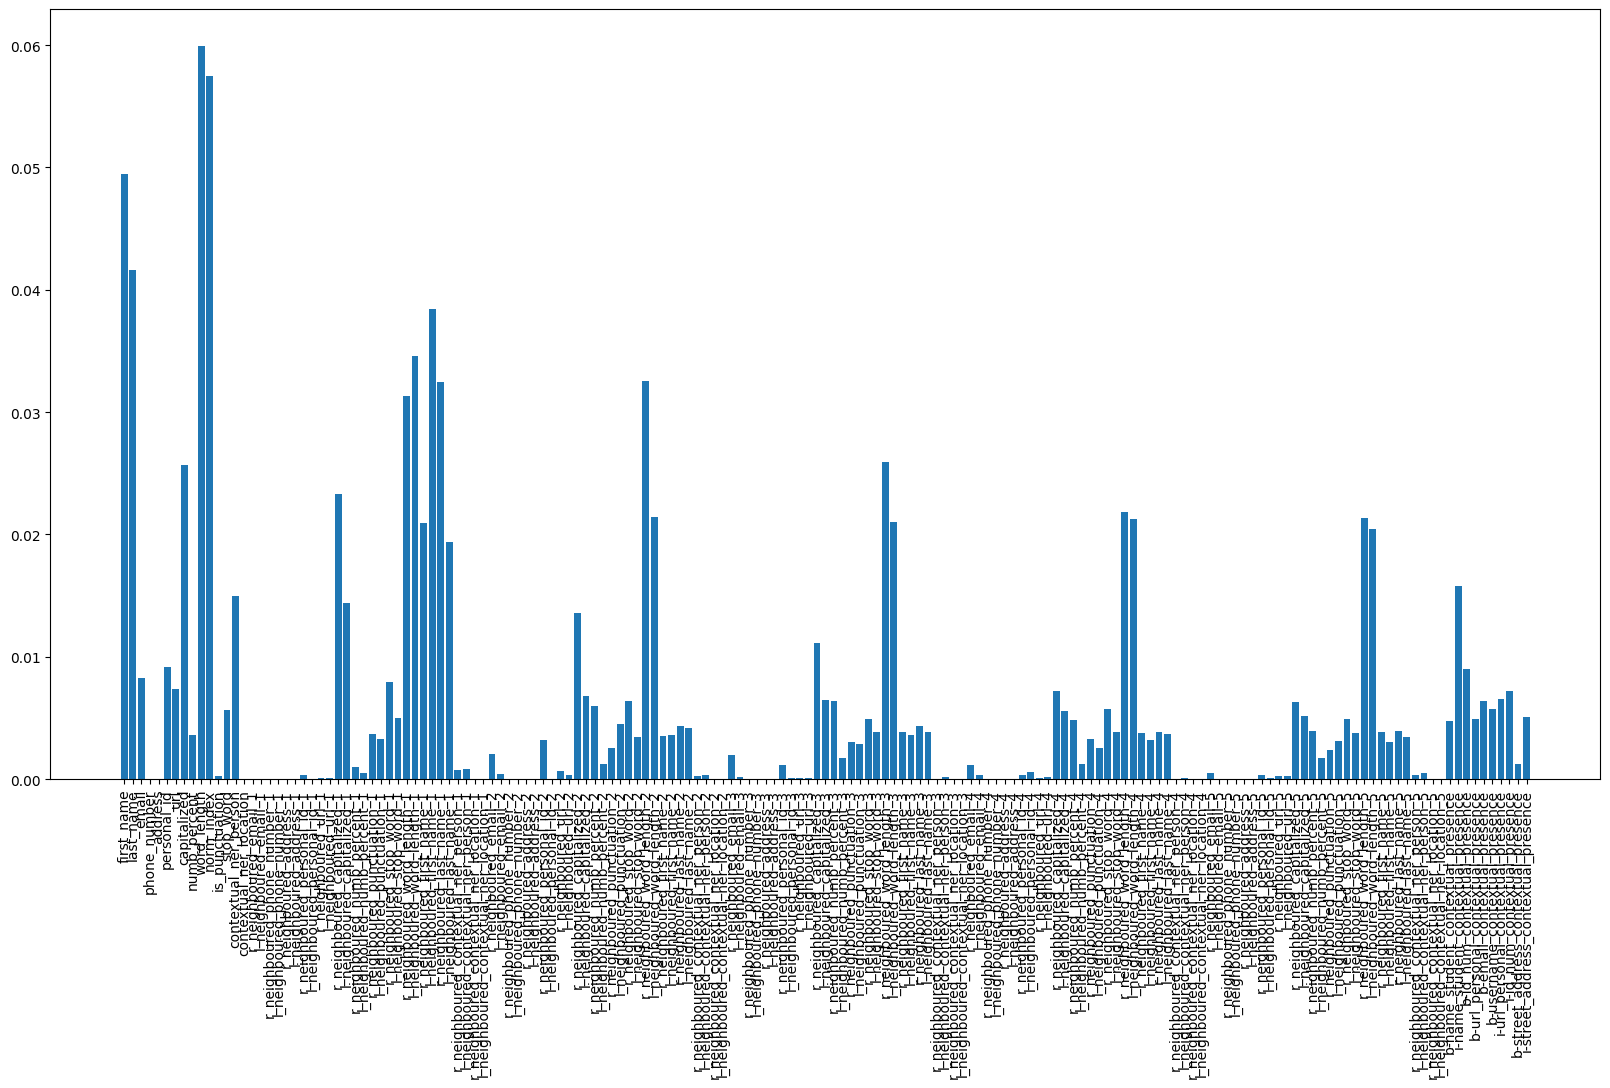

In [89]:
# print feature importance
importances = model.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(X_train.drop(columns=["token", "labels"]).columns, importances)
plt.xticks(rotation=90)
plt.show();